In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:600px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:600px; }</style>")

# Speaker diarization with Gen

<span style="color: red;">This is a preliminary version.</span>

Given an audio file of a conversation our goal is its
segmentation into different speaker tracks, i.e. we would like to determine
*who* speaks *when*.  Along those lines we build a probabilistic speaker segmentation model in [Gen](https://www.gen.dev/), a general-purpose probabilistic programming system, embedded in Julia.

Our model generates speaker similarity matrices of a given size.
In practice such matrices are constructed by creating voice embeddings $X$ vor a given wav file, and computing their similarity, i.e.

$$
    D = X X^T.
$$

To be more precise, we cut the waveform into a collection of (sliding) windows $\{w_i\}$ which then get mapped to a collection of vector embedding $\{ x_i = f(w_i) \}$.
Let $w_i$ and $w_j$ be two such audio snippets from a given wav file and let $x_i$ and $x_j$ define their vector embeddings, then the $ij$'th entry is given by

$$
    d_{i,j} = \langle x_i , x_j \rangle,
$$

where $\langle x , y \rangle$ denotes the dot-product of $x$ and $y$.

Here is a real world example of such a similarity matrix:

<img src="assets/D_obs.png" width="30%">

In contrast, here are a few samples from our probabilistic model:

<img src="assets/D_samples.png" width="100%">

We don't know how many segments or speakers are present a priori, and to sample from the posterior we turn to *Reversible Jump MCMC*, an extension to standard MCMC methodology that allows for simulating from a Markov chain whose state is a vector whose dimension is not fixed.

> “Reversible jump MCMC”, Peter J. Green and David I. Hastie, Genetics 155.3 (2009).

We follow &mdash; to some part &mdash; the example in the Gen ["Reversible-Jump MCMC" tutorial](https://www.gen.dev/tutorials/rj/tutorial) on [gen.dev](https://www.gen.dev). The piecewise constant functions play the role of the speaker tracks in our diarization task.

...

**Quick overview.** 

The notebook is organized as follows:

- We start by defining a few useful distributions that we need down the line.
- Then we define our generative function and a get a feel of what kind of outputs it produces
- Next, we define the inference process.

In [3]:
import PyPlot
plt = PyPlot.plt
plt.style.use("default")
using NPZ
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal, norm, diagm, diagind, diag
import LinearAlgebra
using JSON
using JLD
using StatsBase: Histogram, fit
import StatsBase
using Base.Iterators: flatten

In [4]:
macro bash_str(s) open(`bash`,"w",stdout) do io; print(io, s); end; end;
macro python_str(s) open(`python`,"w",stdout) do io; print(io, s); end; end;

## Useful Distributions

### Dirichlet Dist

The prior for our speaker segments is given by a Dirichlet distribution: Assuming our track length is normalized to 1 we interpret $p=[p_1, ... , p_n]$ with $p_1 + ... + p_n = 1$ as a collection of segment lengths.

That means, **$p_i$ denotes the length of the $i$th segment**. We denote by **$\bar{p_i}$ the endpoint of the $i$th segment, that is, $\bar{p_i} = p_1 + \ldots + p_i$.**

In [5]:
"""
    Dirichlet distribution: `dirichlet(N,a) = Dir(a, ... , a)`
"""
struct Dir <: Gen.Distribution{Vector{Float64}} end
const dirichlet = Dir()
function Gen.logpdf(::Dir, x::AbstractArray{Float64,1}, N::Int, a::Float64)
    dist = Dirichlet(N, a)
    return Distributions.logpdf(dist, x)
end
function Gen.random(::Dir, N::Int, a::Float64)
    dist = Dirichlet(N, a)
    x = rand(dist)
    return x[:,1]
end
(::Dir)(N,a) = Gen.random(Dir(), N, a)
Gen.has_output_grad(::Dir) = false;
Gen.has_argument_grads(::Dir) = (false,);

### Fractions Dist

A useful proposal to change a given set of segment lengths would be to resample a single entry in the partition, or rather redistribute the weights of two consecutive entries $p_i,p_{i+1}$, i.e. chose new weights $q_i,q_{i+1}>0$ with $p_i + p_{i+1} = q_i + q_{i+1}$.

We use a $\beta$-distribution to sample the redistributed weights. [Recall](https://en.wikipedia.org/wiki/Beta_distribution) that 
the mean of `beta(a,b)` is given by `a/(a+b)`. Therefore, given `mu` we can compute b, or a, as a function of a, or b, respectively:

$$
b = \frac{(a - \mu \cdot a)}{\mu}
$$

$$
a = \frac{\mu \cdot b }{ 1-\mu}
$$

Before we define the proposal distribution we quickly take a look at some beta distributions
we are going to use. Depending on the size difference of $p_i$ and $p_{i+1}$ we use different 
values within the beta-distribution.

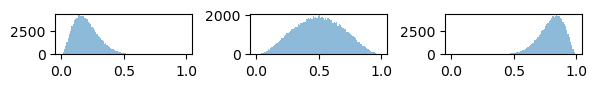

In [6]:
mu1 = 0.2
mu2 = 0.5
mu3 = 1.0 - mu1
C = 3.0
 
a1 = C
b1 = (a1 - mu1*a1)/mu1

a2 = C
b2 = (a2 - mu2*a2)/mu2

b3 = C
a3 = mu3*b3/(1- mu3)

# ----------------
fig, axs = plt.subplots(1,3, figsize=(6,1)); fig.tight_layout();
axs[1].hist([beta(a1,b1) for t=1:100000], bins=0:0.01:1, alpha=0.5);
axs[2].hist([beta(a2,b2) for t=1:100000], bins=0:0.01:1, alpha=0.5);
axs[3].hist([beta(a3,b3) for t=1:100000], bins=0:0.01:1, alpha=0.5);

In [7]:
"""
    refraction(i, seg_lengths, c)

Distribution to let us resample (redistribute) the lengths 
of segments `i` and `i+1`. 

Example:

Suppose we are given `p = [p1, p2, p3, p4]`.

           p1    p2   p3      p4
        [------|----|----|----------]
        0                           1


Calling with `i=2` would resample
segments `2` and `3`, and yield


                  q2   q3           
        [------|------|--|----------]
        0                           1

"""
struct FractionDist <: Gen.Distribution{Vector{Float64}} end
const refraction = FractionDist()
function Gen.logpdf(::FractionDist, x::AbstractArray{Float64,1}, i::Int64, fr::AbstractArray{Float64,1}, c::Float64)
    @assert (0<i && i<length(fr)) 
    mu = fr[i]/(fr[i] + fr[i+1])
    
    if mu < 0.5
        a = c
        b = (a - mu*a)/mu
    elseif mu > 0.5
        b = c
        a = mu*b/(1-mu)
    else
        a = c
        b = c
    end
    
    @assert (a>0 && b>0) "a=$a, b=$b"
    return Gen.logpdf(beta, mu, a, b)
end
function Gen.random(::FractionDist,  i::Int64, fr::AbstractArray{Float64,1}, c::Float64)
    @assert(0<i && i<length(fr))
    X  = fr[i] + fr[i+1] 
    mu = fr[i]/X
    
    if mu < 0.5
        a = c
        b = (a - mu*a)/mu
    elseif mu > 0.5
        b = c
        a = mu*b/(1-mu)
    else
        a = c
        b = c
    end
    
    @assert (a>0 && b>0) "a=$a, b=$b"
    s = beta(a,b)

    return [fr[1:i-1];s*X;(1-s)*X;fr[i+2:end]]
end
(::FractionDist)(i, fr, c) = Gen.random(FractionDist(), i, fr, c)
Gen.has_output_grad(::FractionDist) = false;
Gen.has_argument_grads(::FractionDist) = (false,false,false);

In [8]:
function endpoints(p)
    p_ = cumsum(p)
    p_[end] = 1.0 # Potential numeric issue: `p_[end]` might be 0.999999
    return p_
end;

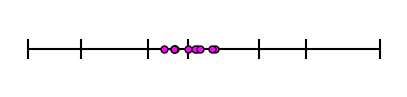

In [9]:
N  = 6
i  = 3
p  = dirichlet(N, 10.0);
p_ = endpoints(p)
Q  = [refraction(i, p, 3.0) for t=1:10]
Q_ = [endpoints(q) for q in Q]

# ----------------------
fig = plt.figure(figsize=(5,1))
plt.scatter(0,0, marker="|", s=200, c="k")
plt.scatter(p_,zeros(N), s=200, marker="|", c="k")
plt.hlines(0,0,1, zorder=0, color="k")

for q_ in Q_
    plt.scatter(q_[i],0, c ="magenta", edgecolor="k",s=25, marker="o")
end
plt.gca().spines."top".set_visible(false)
plt.gca().spines."right".set_visible(false)
plt.gca().spines."left".set_visible(false)
plt.gca().spines."bottom".set_visible(false)
plt.yticks([]);
plt.xticks([]);

### Poisson

We are going to sample the number of segments from a poisson distribution. 
But since we rule out having no segments we add 1.

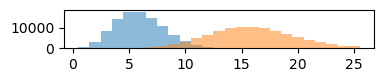

In [10]:
"""
    poisson_plus_one(λ)

A shifted poisson distribution that is guaranteed to be 1 or higher.
"""
@dist poisson_plus_one(rate) = poisson(rate) + 1;
# ------------------------
plt.figure(figsize=(4,0.5))
plt.hist([poisson_plus_one(5)  for t in 1:100_000], bins=0.5:1:25.5, alpha=0.5);
plt.hist([poisson_plus_one(15) for t in 1:100_000], bins=0.5:1:25.5, alpha=0.5);

### Use `Iterators.flatten` and not `vcat` to flatten an array

Just FYI and in case you ever wondered...

In [9]:
x = rand(1_000, 1_000) 
@btime collect(Iterators.flatten(x)); #  1.411 ms (3 allocations: 7.63 MiB)
@btime vcat(x...);                    # 20.374 ms (1000003 allocations: 30.52 MiB)

  1.085 ms (3 allocations: 7.63 MiB)
  20.977 ms (1000003 allocations: 30.52 MiB)


## The generative model

Next we define a model that generates speaker similarity matrices of a given size.
In order to speed up inference we can restrict the model to only create matrix entries 
in a region around the diagonal.

Samples of our model are shown below.

In [11]:
"""
    matrix_model(M::Int                "Max number of speakers",
                 T::Int                "Size of the matrix (or length of the track)",
                 k::Int                "Size of the observation band around diagonal",
                 poisson_rate::Float64 "Parameter shaping the `:num_segments` distribution")

Speaker similarity-matrix model. 
"""
@gen function matrix_model(M::Int, T::Int, k::Int, poisson_rate::Float64)

    #
    # Sampling the number of segments `N` and 
    # their lengths `ls`, and computing
    # their enpoints `ps`
    #
    N  = {:num_segments} ~ poisson_plus_one(poisson_rate)
    ls = {:len_segments} ~ dirichlet(N, 2.0)
    ps = cumsum(ls) 
    ps[end] = 1.0 # Correct numeric issue: `ps[end]` might be 0.999999
    
    #
    # Sampling speaker ids for each segment
    #
    ids = [{(:id, i)} ~ categorical(ones(M)./M) for i=1:N] 

    #
    # Mapping speaker ids to 
    # individual ticks.
    #
    xs  = collect(0:1/(T-1):1)   
    I   = [findfirst(p -> p >= x , ps) for x in xs]
    ys  = ids[I]                 
    
    #
    # Sampling entries for the similarity matrix. We distinguish 
    # 3 different cases:
    #     - Diagonal entries
    #     - Same speaker
    #     - Different speaker
    #     
    # TODO: One could extend this by varying the values based on
    #       speaker similarity
    #
    D = zeros(T,T)
    for i in 1:T, j in max(i-k,1):min(i+k,T)
        if i == j
            # The voice embeddings are normalized so on the 
            # diagonal the entries are 1.
            # TODO: Don't need a random choice here really ...
            D[i,j] = {:D => (i, j)} ~ normal(1, sqrt(0.001))
        else
            # Off-diagonal entries ramp down 
            # from 0.9 towards 0.5
            off = 6
            r = 1 - min(abs(i-j), off)/off
            r = r^2

            if ys[i] == ys[j]
                D[i,j] = {:D => (i, j)} ~ normal(r*0.8 + (1-r)*0.5, sqrt(0.01))
            else
                D[i,j] = {:D => (i, j)} ~ normal(0.15, sqrt(0.007))
            end
            
            # TODO: Add notebook or histograms to show how one
            # arrives at the values 0.5 and 0.15 etc. (Basically looking
            # at a bunch of similarity matrices ...)
        end
    end
    
    return Dict(
        :T   => T,
        :N   => N,
        :ids => ids,
        :xs  => xs,
        :ys  => ys, 
        :D   => D, 
        :ps  => ps,
        :ls  => ls)
end;

Let's look at a few examples of what our model generates and 
get a sense of their quality. 

**Note:** As mentioned in the model definition, in the future 
one should extend the generative function by incorporating diffferent 
levels of speaker similarities. Currently it is just binary: "same" or "different".


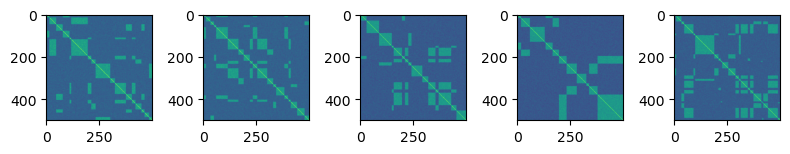

In [20]:
T = 500
M = 10
k = T
λ = 14.
args = (M, T, k, λ);
trs = [simulate(matrix_model, args) for t=1:5]
# ------------------------------------------
fig, axs = plt.subplots(1, 5, figsize=(8,2))
for (i,tr) in enumerate(trs)
    D = get_retval(tr)[:D]
    axs[i].imshow(D)
end
fig.tight_layout()

**Note:** Unfortunately it is quite expensive to sample each entry in the matrix. 
That leaves a lot of room for performance engineering.

In [12]:
@btime tr = simulate(matrix_model, args);

  308.522 ms (3628850 allocations: 122.99 MiB)


### Trace helper

In [15]:
"""
    make_obs(D) -> choicemap

Conveniently create a observation choicemap 
from a similarity matrix.
"""
function make_obs(D)
    H,W = size(D)
    ch = choicemap()
    for i=1:H, j=i:W
        ch[:D => (i, j)] = D[i,j]
        ch[:D => (j, i)] = D[j,i]
    end
    return ch
end;

In [16]:
"""
    make_speaker_map(tr) -> im

Creates a block matrix colored by speaker id,
To quickly visualize a model trace.
"""
function make_speaker_map(tr)
    M,T, = get_args(tr)
    SM   = zeros(T,T)
    ys   = get_retval(tr)[:ys]
    
    relabel = Dict()
    key_count = 1
    for i=1:T
        if !haskey(relabel, ys[i])
            relabel[ys[i]] = key_count
            key_count += 1
        end
        ys[i] = relabel[ys[i]]
    end

    for i=1:T
        for j=1:T
            a = float(ys[i] == ys[j])
            SM[i,j] = a*ys[i]
        end
    end
    SM[SM.==0] .= NaN
    return SM
end;

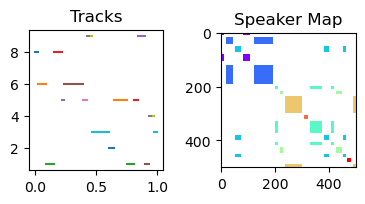

PyObject <matplotlib.image.AxesImage object at 0x7fc7b6980790>

In [42]:
"""
    plot_speaker_tracks(tr)

"""
function plot_speaker_tracks(tr)
    ids = tr[][:ids]
    ls = tr[][:ls]
    ps = tr[][:ps]
    N = size(ids,1)
    keymap = Dict()
    key = 0
    segs = hcat([0; ps[1:end-1]], ps[1:end])
    sp_map = make_speaker_map(tr)
    # ------------------------------------------
    fig, axs = plt.subplots(1,2,figsize=(4,2))
    fig.tight_layout()
    axs[1].set_title("Tracks");
    for i in 1:N
        axs[1].plot(segs[i,:],[ids[i],ids[i]]); 
    end
    axs[2].set_title("Speaker Map");
    axs[2].imshow(sp_map, cmap="rainbow"); 
end;

tr = trs[1]
plot_speaker_tracks(tr)

In [17]:
"""
    make_prob_map(tr)

Returns a matrix who's entries contain 
the probability of the observed pixel.
Shows how well the choices explain 
the observations.
"""
function make_prob_map(tr)
    M,T, = get_args(tr)
    P    = zeros(T,T)
    for i in 1:T
        for j in i:T
            p_ij = project(tr, select(:D => (i, j)))
            P[i,j] = exp(p_ij)
            P[j,i] = exp(p_ij)
        end
    end
    return P
end;

In [18]:
function plot_tr(tr; figsize=(5,2))
    M, = get_args(tr)
    D  = get_retval(tr)[:D]
    sp_map = make_speaker_map(tr)
    # ------------------------------------------
    fig, axs = plt.subplots(1,2,figsize=figsize)
    fig.tight_layout()
    axs[1].set_title("Observation");
    axs[1].imshow(D, vmin=0., vmax=1.); 
    axs[2].set_title("Speaker Map");
    axs[2].imshow(sp_map, cmap="rainbow"); 
end;

In [19]:
"""
    save_ani_frame!(tr, fname, F)

Saves a png to disc and collects the fname.
"""
function save_ani_frame!(tr, fname, F)
    
    push!(F, fname)    
    plot_tr(tr);
    plt.savefig(fname, bbox_inches="tight", dpi=250)
    plt.close()
end;

### Naive inference - A quick reality check

Next we apply a quick reality check and see if we can infer 
speaker segments through importance sampling. I.e. sample a bunch 
of examples and pick the one that fits the observations best. 

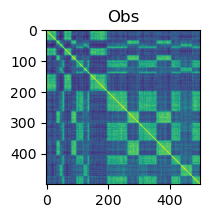

In [20]:
D = npzread("assets/D.npy") 
# --------
fig, axs = plt.subplots(1,1,figsize=(2,2))
axs.set_title("Obs")
axs.imshow(D); 

Keeping all traces in memory is expensive, so to get more iterations we just keep the best (highest score) trace around.

In [23]:
T = 100
M = 10
k = T
λ = 4.
args = (M, T, k, λ);
obs  = make_obs(D[1:T,1:T]);

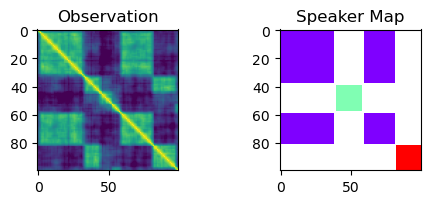

In [24]:
w_max  = -Inf
tr_max = nothing
for t = 1:1_000
    if t%100 == 0; print("$t \r"); flush(stdout); end
    tr, w = generate(matrix_model, args, obs);
    if w > w_max
        w_max, tr_max  = w, tr
    end
end
# -----------
plot_tr(tr_max);

A naive brute force approach is usually too expensive to infer all segments correctly.
We have to guide the inference process to get better inference results.

## Reversible Jump MCMC

Reversible-jump Markov chain Monte Carlo is an extension to standard Markov chain Monte Carlo (MCMC) methodology that allows for simulating from a Markov chain whose state is a vector whose dimension is not fixed. Thus, the simulation is possible even if the number of parameters in the model is not known.


> “Reversible jump MCMC”, Peter J. Green and David I. Hastie, Genetics 155.3 (2009).

Another good resource to see an example of Reversible Jump MCMC is 
the Gen ["Reversible-Jump MCMC" tutorial](https://www.gen.dev/tutorials/rj/tutorial) on [gen.dev](https://www.gen.dev). The piecewise constant functions play the role of the speaker tracks in our diarization task.

In our case, we don't know how many segments or speakers are present a priori. The functions `proposal` and `involution` below implement the distribution $g(u)$ and invertible function $h(x,u)$ in (Green-Hastie, 2009).

**To do:** What are other suitable split and merge moves for speaker inference?

```
    prop(t, args) --> ch, ret
    i(t , ch , ret   , args) --> t', ch', w'
    i(t', ch', ret ? , args) --> t , ch , w
```

### Proposal

In [21]:
@gen function proposal(tr)
    
    M, = get_args(tr)
    N  = tr[:num_segments]
    fr = tr[:len_segments]
    
    if ({:split} ~ bernoulli(N == 1 ? 1 : 0.3))
        
        # which segment to split
        # where to split
        # which id to keep and which to resample
        # new id
        {:i} ~ uniform_discrete(1, N)
        {:split_fraction} ~ uniform(0, 1)
        {:keep_right} ~ bernoulli(0.5)
        {:new_id} ~ uniform_discrete(1, M)
        
    else
        # which segments to merge (i,i+1)
        # which id to use for the merged segment
        {:i} ~ uniform_discrete(1, N-1)
        {:keep_right} ~ bernoulli(0.5)
        
    end
end;

### Involution

In [22]:
function involution(tr, ch, ret, _)
    
    M, = get_args(tr)
    N  = tr[:num_segments]
    fr = tr[:len_segments]


    if ch[:split]
        # 
        # Split move
        # ----------
        #
        i = ch[:i]
        s = ch[:split_fraction]

        
        upd = choicemap()
        upd[:num_segments] = N + 1
        upd[:len_segments] = [fr[1:i-1]; s*fr[i]; (1-s)*fr[i]; fr[i+1:end]]
        
        
        for j = N:-1:i+1
            # updates from i+2 onward....
            upd[(:id, j+1)] = tr[(:id, j)]
        end
            
        # updates from i, and i+1
        if ch[:keep_right]
            upd[(:id, i)]   = ch[:new_id]  # new
            upd[(:id, i+1)] = tr[(:id, i)] # keep
        else
            upd[(:id, i)]   = tr[(:id, i)] # keep
            upd[(:id, i+1)] = ch[:new_id]  # new
        end
    
    else
        # 
        # Merge move
        # ----------
        # 
        i = ch[:i]
        
        upd = choicemap()
        upd[:num_segments] = N - 1
        
        upd[:len_segments] = [fr[1:i-1]; fr[i] + fr[i+1]; fr[i+2:end]]
        
        
        if ch[:keep_right]    
            upd[(:id, i)] = tr[(:id, i + 1)]  
        end
        
        for j = i+1:N-1
            upd[(:id, j)] = tr[(:id, j+1)]
        end
        
        
        

        
    end
    
    #
    # Backwards updates
    # -----------------
    # I.e. in case of a split set the choices so a merge gets 
    # us back to the original constellation pre-split. 
    # 
    # Similar for the case of a merge set the choices so a split
    # gets us back to the pre-merge state.
    #
    
    ch_ = choicemap()
    ch_[:split] = !ch[:split]
    
    if ch[:split]
        ch_[:keep_right] = ch[:keep_right]
        ch_[:i] = i
    else
        if ch[:keep_right]    
            ch_[:new_id] = tr[(:id, i)]     
        else
            ch_[:new_id] = tr[(:id, i + 1)] 
        end
        
        ch_[:split_fraction] = fr[i]/(fr[i] + fr[i+1])
        ch_[:i] = i
        ch_[:keep_right] = ch[:keep_right]
    end
    
    
    new_trace, weight, = update(tr, get_args(tr), (NoChange(),), upd)
    (new_trace, ch_, weight)
end;

### Fractions proposal

We define a proposal using the `refraction` distribution 
from the top of the notebook to adjust segment lengths.

In [27]:
@gen function fractions_proposal(tr, i)
    ps = tr[:len_segments]
    qs = {:len_segments} ~ refraction(i, ps, 3.)
end;

## Inference

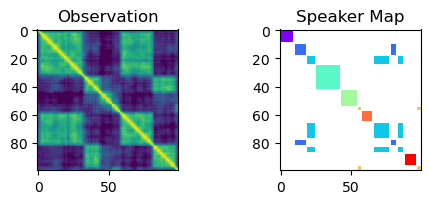

In [95]:
T = 100
M = 10
k = T
λ = 6.0
args = (M, T, k, λ);

D   = npzread("assets/D.npy")
obs = make_obs(D[1:T,1:T]);

tr, w = generate(matrix_model, args, obs);
# --------
plot_tr(tr);

In [98]:
bash"""
mkdir -p _temp
rm _temp/*
"""

tr_ = tr
F   = []
for c1=1:100
        
    save_ani_frame!(tr_, "_temp/$(c1).png" , F)
    
    tr_, a = mh(tr_, proposal, (), involution)
    N = tr_[:num_segments]
    for i=1:N
        for c2=1:3
            if i < N
                tr_, a = mh(tr_, fractions_proposal, (i,));
            end
            
        end
        for c2=1:3
            tr_, = mh(tr_, select((:id, i)))
        end
    end
    
    print("$c1 \r"); 
end

I am using Python to create the animation &mdash; just easier atm because I have the code ready to go.

In [115]:
F_ = []
for f in F
    push!(F_,f)
    push!(F_,f)
    push!(F_,f)
end

In [119]:
import JSON
open("_F.json", "w") do f 
    write(f, JSON.json(F)) 
end;

python"""
from cgnai.plotting import ani
from cgnai.fileio import ls, load

# load the frame fnames
F = load("_F.json")[:40]

# Create the gif animation
fname = "assets/ani.gif"
ani(fname, F)
"""

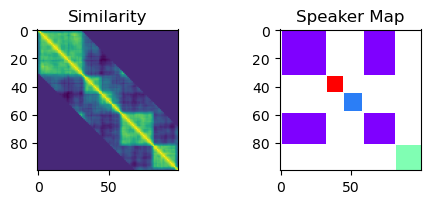

In [107]:
plot_tr(tr_);

# Animations

# Naive inference

In [129]:
bash"""
mkdir -p _temp
"""

T = 100
M = 10
k = T
λ = 4.
args = (M, T, k, λ);
obs  = make_obs(D[1:T,1:T]);

F = []
w_max  = -Inf
tr_max = nothing
for t = 1:100
    if t%100 == 0; print("$t \r"); flush(stdout); end
    tr, w = generate(matrix_model, args, obs);
    if w > w_max
        w_max, tr_max  = w, tr
    end
    
#     if t%1 == 0
        save_ani_frame!(tr_max, "_temp/$(t).png" , F)
#     end
end

In [130]:
F_ = []
for f in F
    push!(F_,f)
    push!(F_,f)
    push!(F_,f)
end

import JSON
open("_F.json", "w") do f 
    write(f, JSON.json(F_)) 
end;

python"""
from cgnai.plotting import ani
from cgnai.fileio import ls, load

# load the frame fnames
F = load("_F.json")[:40]

# Create the gif animation
fname = "assets/naive_inference.gif"
ani(fname, F)
"""